# Khai báo thư viện

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima  import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,accuracy_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input,GRU
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import xgboost as xgb
from keras import Model
import math
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

# Đọc Dữ Liệu

In [3]:
df = pd.read_csv('Amazon_Stock_Price.csv')
df.head(5)

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2000-01-03,4.075,4.478,3.952,4.469,322352000
1,1,2000-01-04,4.269,4.575,4.088,4.097,349748000
2,2,2000-01-05,3.525,3.756,3.400,3.487,769148000
3,3,2000-01-06,3.566,3.634,3.200,3.278,375040000
4,4,2000-01-07,3.350,3.525,3.309,3.478,210108000


In [4]:
df = pd.read_csv('Amazon_Stock_Price.csv',
                 parse_dates=True
                )

In [5]:
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
df.drop(columns=['Volume'],axis=1,inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

## Data Overview

In [7]:
df.head(10)

,Date,Open,High,Low,Close
0,2000-01-03,4.075,4.478,3.952,4.469
1,2000-01-04,4.269,4.575,4.088,4.097
2,2000-01-05,3.525,3.756,3.400,3.487
3,2000-01-06,3.566,3.634,3.200,3.278
4,2000-01-07,3.350,3.525,3.309,3.478
5,2000-01-10,3.628,3.631,3.278,3.459
6,2000-01-11,3.344,3.500,3.250,3.338
7,2000-01-12,3.394,3.400,3.150,3.178
8,2000-01-13,3.247,3.359,3.156,3.297
9,2000-01-14,3.338,3.431,3.200,3.213


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6050 entries, 0 to 6049
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6050 non-null   datetime64[ns]
 1   Open    6050 non-null   float64       
 2   High    6050 non-null   float64       
 3   Low     6050 non-null   float64       
 4   Close   6050 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 236.5 KB


# Trực quan hóa dữ liệu

Kiểm tra tính dừng của dữ liệu

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.427528
p-value: 0.982496


Biểu đồ thời gian về giá đóng của cố phiếu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


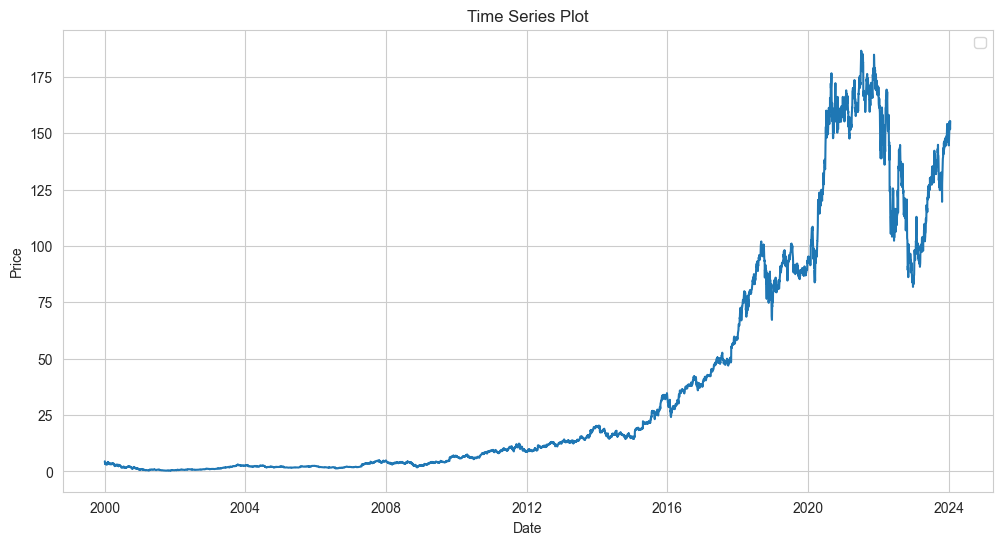

In [10]:
price_data = df['Close']
date_data = df['Date']
plt.figure(figsize=(12, 6))
plt.plot(date_data,price_data)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Biểu đồ về trend , seasonal và resid của dữ liệu

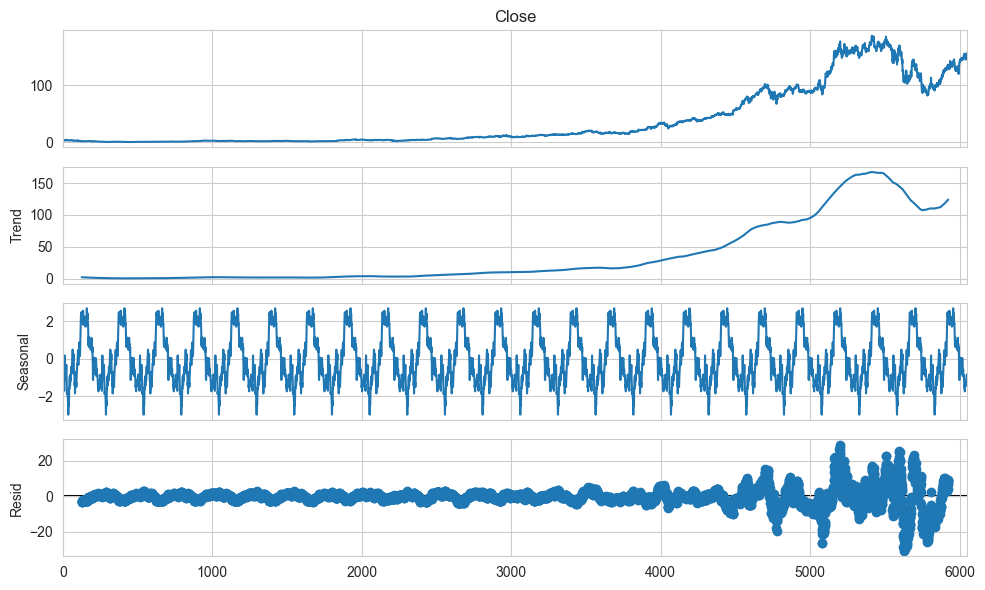

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose chuỗi thời gian
decomposition = seasonal_decompose(price_data, model='additive', period=252)  # Giả sử chu kỳ mùa vụ là 252 (ngày giao dịch trong 1 năm)
fig = decomposition.plot()
plt.show()

Biểu đồ tương quan (autocorrelation)

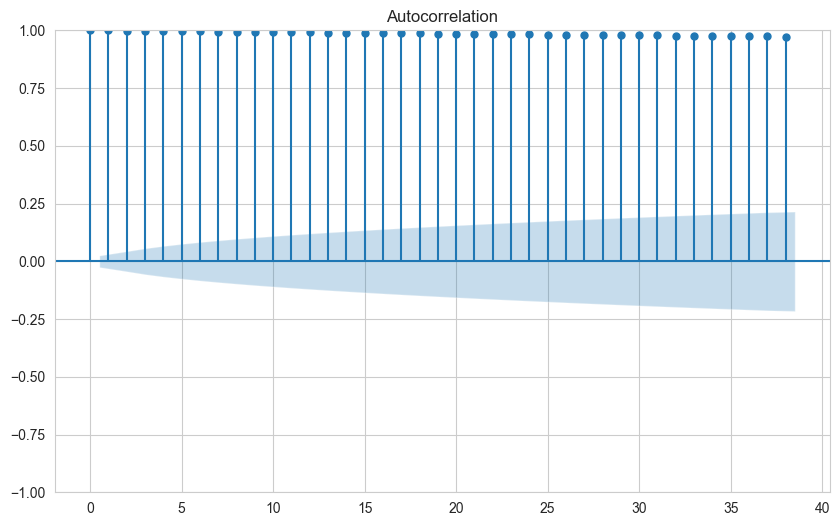

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Close'])
plt.show()

Biều đồ giá cổ phiếu 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


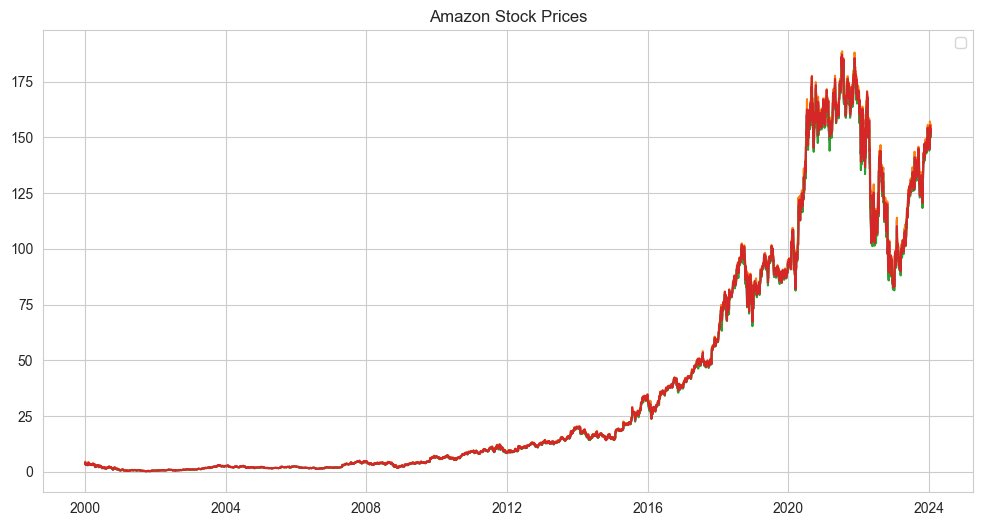

In [13]:
df_plt = df[['Close','High','Low','Open']]
plt.figure(figsize=(12, 6))
plt.plot(date_data,df_plt)
plt.title('Amazon Stock Prices')
plt.legend()

<Axes: >

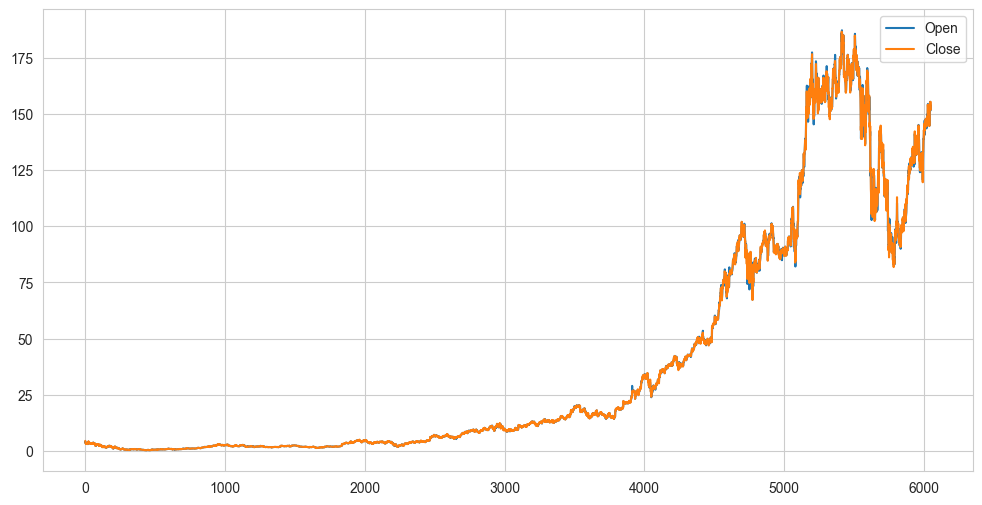

In [14]:
df[['Open','Close']].plot(figsize=(12,6))

# Chia dữ liệu thành tập huyến luyện và tập kiểm thử

In [15]:
test_size = df[df.Date.dt.year==2024].shape[0]
test_size

13

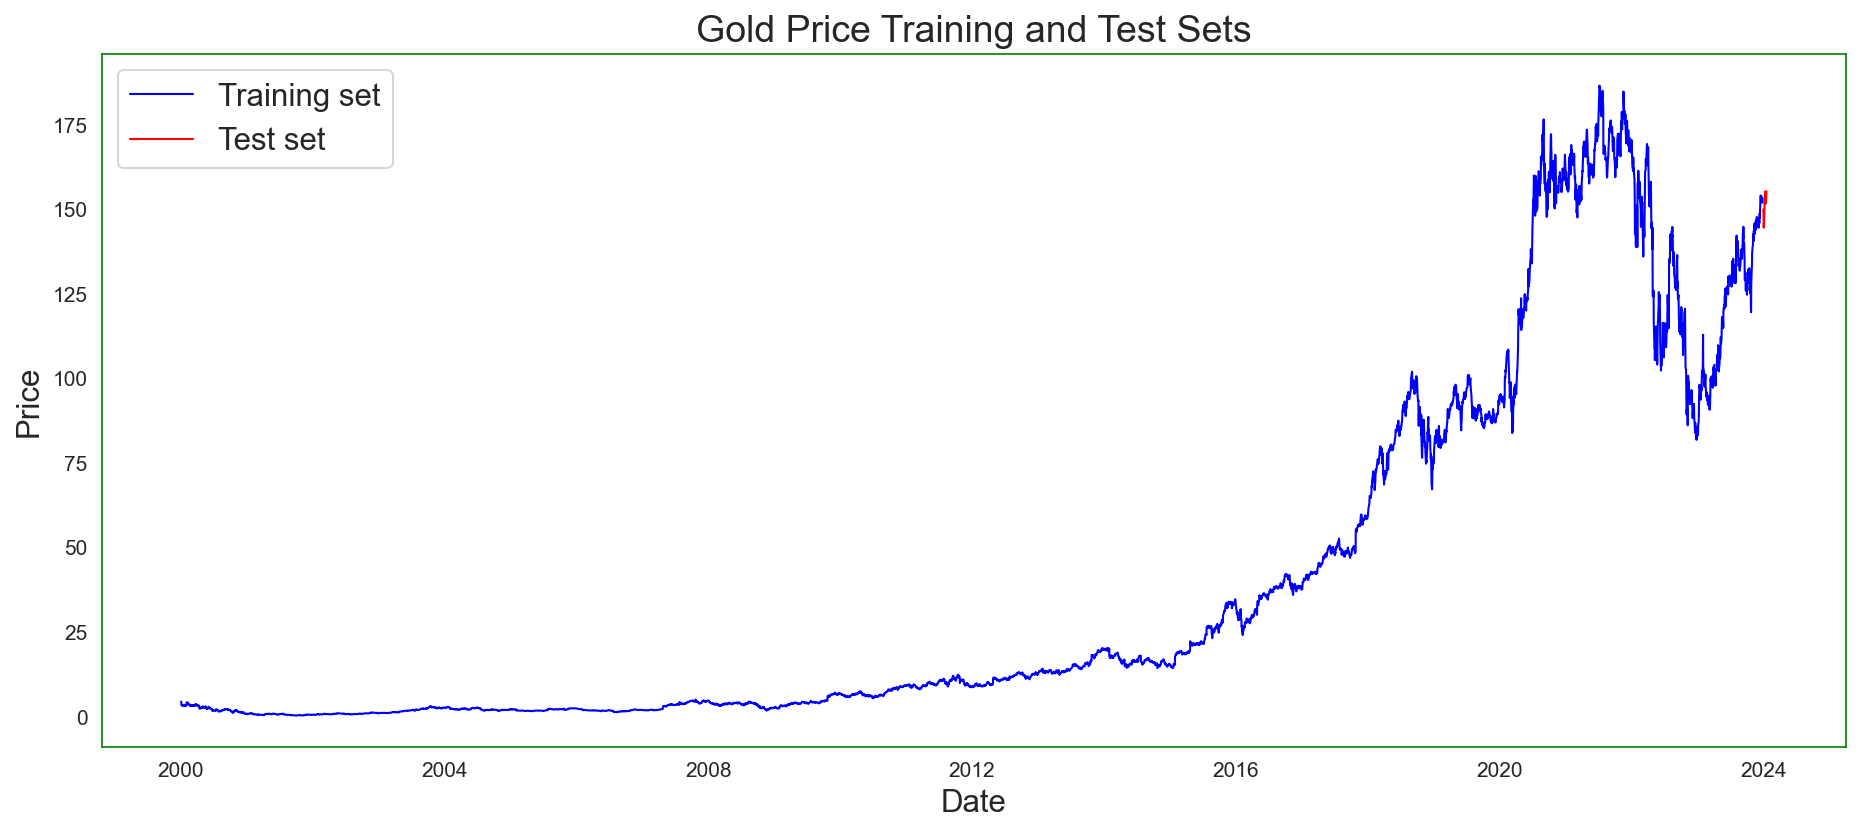

In [16]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='green')
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='blue', lw=1)
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='red', lw=1)
plt.title('Gold Price Training and Test Sets', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
scaler.fit(df.Close.values.reshape(-1,1))

MinMaxScaler()

In [19]:
window_size = 60

Trainning set:

In [20]:
train_data = df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [21]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

Test set:

In [22]:
test_data = df.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [23]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Chuyển dữ liệu sang Numpy Arrays

In [24]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [25]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [26]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (5977, 60, 1)
y_train Shape:  (5977, 1)
X_test Shape:   (13, 60, 1)
y_test Shape:   (13, 1)


# Khởi tạo model

## Model LSTM

In [27]:
def define_model_lstm():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 128, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 32,return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 16)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [28]:
model_lstm = define_model_lstm()
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,097 (516.00 KB)

 Trainable params: 132,097 (516.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.0396 - val_loss: 0.0452
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.0017 - val_loss: 0.0096
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 7.8943e-04 - val_loss: 0.0101
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 7.3510e-04 - val_loss: 0.0048
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 5.3093e-04 - val_loss: 0.0077
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 5.2329e-04 - val_loss: 0.0083
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 4.2254e-04 - val_loss: 0.0047
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 4.5492e-04 - val_loss: 0.0050
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 6.1361e-04 - val_loss: 0.0067
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 4.9689e-04 - val_loss: 0.006

## Model GRU

In [29]:
def define_model_gru():
    input1 = Input(shape=(window_size,1))
    x = GRU(units = 128, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = GRU(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = GRU(units = 32,return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = GRU(units = 16)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [30]:
model_gru = define_model_gru()
history1 = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 60, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,937 (390.38 KB)

 Trainable params: 99,937 (390.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - loss: 0.0586 - val_loss: 0.0763
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 0.0081 - val_loss: 0.0154
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0030 - val_loss: 0.0072
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 9.6257e-04 - val_loss: 0.0066
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 7.9809e-04 - val_loss: 0.0082
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 7.1138e-04 - val_loss: 0.0136
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 6.9539e-04 - val_loss: 0.0175
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 6.2751e-04 - val_loss: 0.0112
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 5.5177e-04 - val_loss: 0.0082
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 6.7453e-04 - val_loss: 0.0161
Ep

## SARIMA

In [31]:

# Lấy dữ liệu huấn luyện không chuẩn hóa để huấn luyện mô hình SARIMA
train_data_sarima = df['Close'][:-test_size]
stepwise_fit= auto_arima(train_data_sarima,seasonal=True,m = 1,trace= True,suppress_warnings=True,stepwise=True)
print(stepwise_fit.summary())



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20896.405, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20894.266, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20894.329, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20896.336, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20895.848, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20889.741, Time=0.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20891.226, Time=3.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20891.161, Time=1.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20896.047, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=20889.748, Time=0.38 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 15.299 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:            

In [32]:
# Lấy các tham số từ mô hình auto_arima
order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order
print(order)
print(seasonal_order)

(1, 1, 1)
(0, 0, 0, 0)


In [33]:
sarima_model = SARIMAX(train_data_sarima, order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

In [34]:
sarima_forecast = sarima_results.get_forecast(steps=test_size)
sarima_pred = sarima_forecast.predicted_mean

# Đánh giá mô hình

## Mô hình LSTM

In [35]:
result_lstm = model_lstm.evaluate(X_test, y_test)
y_pred_lstm = model_lstm.predict(X_test) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0011
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


In [36]:
MAPE = mean_absolute_percentage_error(y_test, y_pred_lstm)
Accuracy = 1 - MAPE

In [37]:
print("Test Loss:", result_lstm)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0010796712012961507
Test MAPE: 0.03535962640604201
Test Accuracy: 0.9646403735939579


## Mô hình GRU

In [38]:
result_gru = model_gru.evaluate(X_test, y_test)
y_pred_gru= model_gru.predict(X_test) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 4.7515e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


In [39]:
MAPE = mean_absolute_percentage_error(y_test, y_pred_gru)
Accuracy = 1 - MAPE

In [40]:
print("Test Loss:", result_gru)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0004751545493490994
Test MAPE: 0.02140944874245591
Test Accuracy: 0.9785905512575441


## Mô hình SARIMA

In [41]:
# Tính toán các độ đo đánh giá
sarima_test_actual = df['Close'][-test_size:].values
sarima_test_pred = sarima_pred.values


In [42]:
mse_sarima = mean_squared_error(sarima_test_actual, sarima_test_pred)
mae_sarima = mean_absolute_error(sarima_test_actual, sarima_test_pred)
mape_sarima = np.mean(np.abs((sarima_test_actual - sarima_test_pred) / sarima_test_actual)) * 100


In [43]:
print(f'SARIMA MSE: {mse_sarima}')
print(f'SARIMA MAE: {mae_sarima}')
print(f'SARIMA MAPE: {mape_sarima}')

SARIMA MSE: 12.368983687552824
SARIMA MAE: 2.8557571589156554
SARIMA MAPE: 1.9110692083196945


# Trực quan hóa kết quả dự đoán

In [44]:
y_test_true = scaler.inverse_transform(y_test)

Model LSTM

In [45]:
y_test_pred_lstm = scaler.inverse_transform(y_pred_lstm)

Model GRU

In [46]:
y_test_pred_gru = scaler.inverse_transform(y_pred_gru)

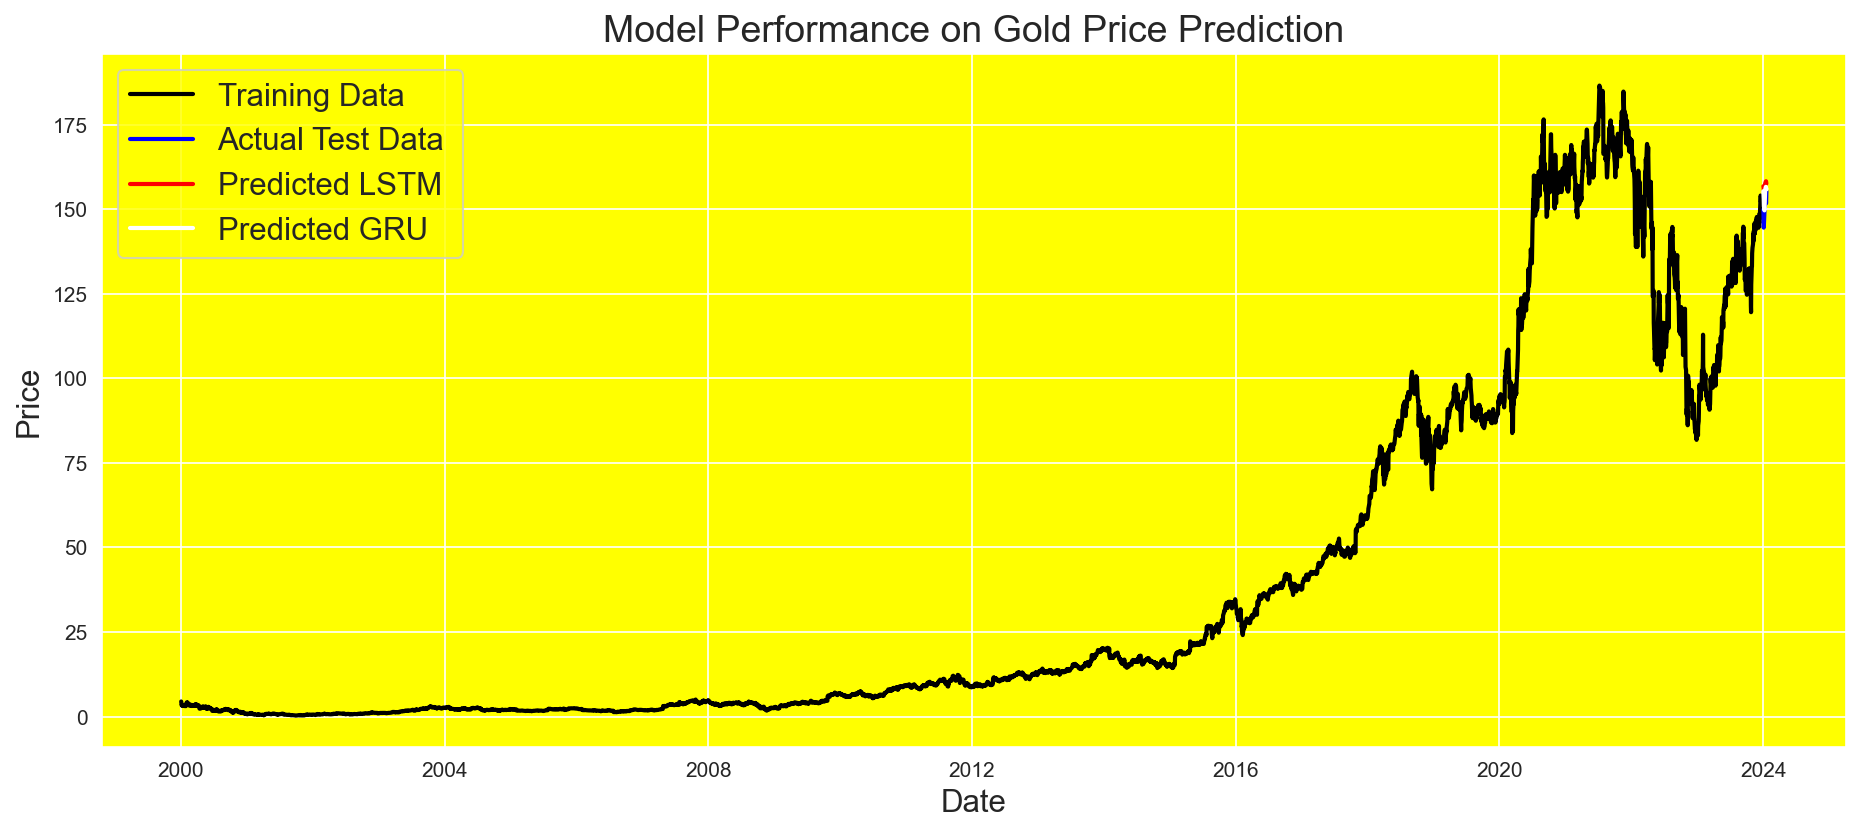

In [47]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred_lstm, color='red', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred_gru, color='white', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted LSTM ','Predicted GRU'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

Model Sarima

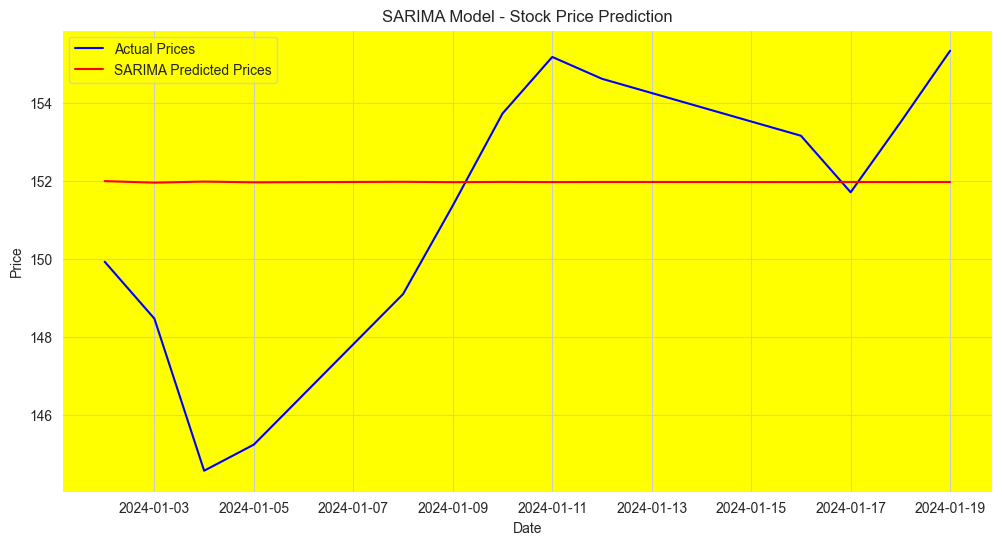

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(df.Date[-test_size:], sarima_test_actual, label='Actual Prices', color='blue')
plt.plot(df.Date[-test_size:], sarima_test_pred, label='SARIMA Predicted Prices', color='red')
plt.title('SARIMA Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()